In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import math
import requests
import sqlite3
import datetime
import time
import os
import json
import io
import xlrd
import ciso8601
import urllib3
import http.client
from numpy import cos, sin, arcsin, sqrt
from math import radians
from dateutil.parser import parse
from scipy import stats
from datetime import date
import earthpy as et
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [ ]:
# older data is bad
start_year = 2018
s_date = datetime.datetime(year=start_year,month=1,day=1)
####
conn = sqlite3.connect('flights_data.db') # 3GB file. data from 2015
c = conn.cursor()
#### LIST AND DETAILS OFF THE 50 AIRPORTS I AM TRACKING
airports_headers = ['ident','name','latitude_deg','longitude_deg',              # from a database of global airports   
'continent','iso_country','iso_region','gps_code','iata_code','PADD']
ARIP_DATA = pd.read_csv('C:/Users/Moses/Python/flights_data/airports_list.csv') # file uploaded       
ARIP_H = ['iata','city','state','icao24','latitude_deg','longitude_deg']        # airports data headers
ARIP_LIST = ARIP_DATA['icao24'].tolist()                                        # list of airports we want to track
MODE = ['Departures']                                                           # Arrivals/Departures
arip_subset = ['index','icao24','callsign','estDepartureAirport','estArrivalAirport','lastSeen','latitude_deg','longitude_deg']
### DATABASE OF ALL AIRPORTS GLOBALY
SUB_HEADERS = ['ident','name','latitude_deg','longitude_deg','continent','iso_country','iso_region','gps_code','iata_code','PADD','state_province']
ARIP_MASTER =  pd.read_csv('C:/Users/Moses/Python/flights_data/airports_icao.csv')
ARIP_MASTER = ARIP_MASTER[SUB_HEADERS]       # read airports file

#### Reading historical jet fuel demand data by padd and energy aspects forecast

In [635]:
### JET DEMAND
EA_JET = pd.read_csv('ea_jet.csv',header=0,index_col=0)
EA_JET['date'] = EA_JET['date'].astype('datetime64[ns]')
# temp_index = EA_JET.index.to_list()
EA_JET.set_index(["date"], inplace = True, drop = False)
EA_JET = EA_JET.rename_axis("period")
s_date = datetime.datetime(year=2019,month=1,day=1)
EA_JET=EA_JET[EA_JET['date'] >= s_date]
BALANCES = EA_JET
BALANCES.head()

,Days in Month,Year,month,date,PADD 1,PADD 2,PADD 3,PADD 4,PADD 5,Canada,NA_TOTAL,US
period,,,,,,,,,,,,
2019-01-01,31,2019,1,2019-01-01,580,280,209,57,503,162,"1,792","1,629"
2019-02-01,28,2019,2,2019-02-01,576,275,211,56,485,156,"1,760","1,603"
2019-03-01,31,2019,3,2019-03-01,694,293,150,57,515,150,"1,860","1,709"
2019-04-01,30,2019,4,2019-04-01,615,289,214,61,571,170,"1,921","1,750"
2019-05-01,31,2019,5,2019-05-01,647,311,222,57,544,149,"1,931","1,781"


In [ ]:
# SQL QUERY. DONT RUN OFTWN
strg = "SELECT * FROM DeparturesRaw WHERE lastSeen between '2019-01-01 00:00:00' AND '2020-06-02 00:00:00'"
result = c.execute(strg).fetchall()

In [ ]:
raw_headers=['index','icao24','callsign','estDepartureAirport','estArrivalAirport','lastSeen']
RAW_DATA = pd.DataFrame(result,columns=raw_headers) # data for the AA airport
RAW_DATA.drop(columns=['index'],inplace=True)  # SQL added an index column
# DONT RUN ABOVE THIS. HEAVY STUFF

In [ ]:
# LOOKING UP PADD REGION and GEO COORDINATES FOR THE ORIGIN AIRPORT
cleaned = pd.merge(RAW_DATA, ARIP_MASTER,how = 'left',left_on = 'estDepartureAirport',right_on = 'ident')
cleaned.rename(columns={'PADD': 'orig_padd','latitude_deg': 'orig_lat','longitude_deg': 'orig_lon'}, inplace=True)              # set origin pad
arip_subset = ['icao24','callsign','estDepartureAirport','estArrivalAirport','lastSeen','orig_lat','orig_lon','orig_padd']
cleaned = cleaned[arip_subset]          # drop the rest
# cleaned.head()
#### NOW SOME GOOD DETAILS ON DESTINATION 
cleaned = pd.merge(cleaned, ARIP_MASTER,how = 'left',left_on = 'estArrivalAirport',right_on = 'ident')
cleaned.drop(columns=['ident','name','iata_code','gps_code'],inplace=True)
cleaned.rename(columns={'estDepartureAirport':'departure_airport','estArrivalAirport':'arroival_airport'}, inplace=True)        # set origin pad
cleaned.rename(columns={'PADD': 'dest_padd','latitude_deg': 'dest_lat','longitude_deg': 'dest_lon'}, inplace=True)              # set origin pad
cleaned.rename(columns={'continent':'dest_continent','dest_iso_country':'iso_country', 'dest_iso_region':'iso_region','dest_state_province':'state_province'}, inplace=True)    # set origin pad
#222check where those callsign that dont report origin etc have done before or not?

In [ ]:
# %% calculates distance without relying on external APIs
# even better than the HAVERSINE and GEOPY packages. 
# Those package relies on Google geo services etc.
# and I will hit the limit quite quickly
def CalcDistance(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    ml = km * 0.621371
    return ml

In [ ]:
cleaned['distance'] = CalcDistance(cleaned['orig_lon'],cleaned['orig_lat'],cleaned['dest_lon'],cleaned['dest_lat'])
cleaned['lastSeen'] = cleaned['lastSeen'].astype('datetime64[ns]')
cleaned['timestamp'] = cleaned['lastSeen']
cleaned.set_index(["timestamp"], inplace = True, drop = True)

In [359]:
#### DO NOT TOUCH ANYTHING HERE ########
#### MAKING A COPY ########
df = cleaned
df['lastSeen'] = df['lastSeen'].astype('datetime64[ns]')
df['date'] = df['lastSeen'].dt.date
df['year'] = df['lastSeen'].dt.year
df['month'] = df['lastSeen'].dt.month
df['day'] = df['lastSeen'].dt.day
#### DO NOT TOUCH ANYTHING HERE ########
#### MAKING A COPY ########

In [454]:
# df.head()

### Selecting PADD regions here. or airport.

In [674]:
PADD_NUM = 4

df2 = df[df['orig_padd'] == PADD_NUM]
# df2 = df[df['departure_airport'] == 'KJFK']
df2['year'] = df2['lastSeen'].dt.year
df2['month'] = df2['lastSeen'].dt.month
df2['day'] = df2['lastSeen'].dt.day
df2.drop(columns=['orig_lat','orig_lon','dest_lat','dest_lon','lastSeen'],inplace=True)

# UPSAMPLING

### daily first

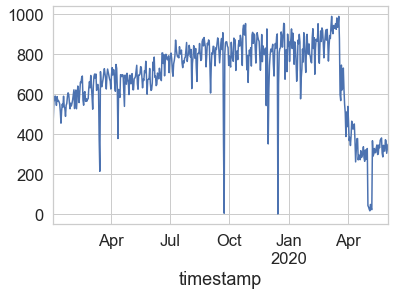

In [675]:
# UPSAMPLING TO GET DAILY-WEEKLY-MONTHLY DATA
# THIS IS DAILY
ma_window = 7
ma_window_2 = 14
distance_avg = df2.resample("D", label='right', closed = 'right').mean()
distance_avg = distance_avg['distance']
count_daily = df2.resample("D", label='right', closed = 'right').count()
count_daily = count_daily['icao24']
# add them UP
DAILY = pd.concat([distance_avg, count_daily], axis=1)
DAILY.rename(columns={'distance': 'avg_flight_dist','icao24': 'daily_departures'}, inplace=True)
#### replace missing data with NaN so i can replace them
# calculate moving average - 14 day
DAILY['daily_departures_7MA'] = DAILY['daily_departures'].rolling(window=ma_window,min_periods=1).mean()
DAILY['avg_flight_dist_7MA'] = DAILY['avg_flight_dist'].rolling(window=ma_window,min_periods=1).mean()
# Data is really crappy
DAILY['daily_departures'].plot(kind='line', x='date', y='daily_departures', alpha=1)

### data clealry needs to be cleaned

In [676]:
### drop the values that are 30% below 7-day average
DAILY.loc[DAILY['daily_departures'] < DAILY['daily_departures_7MA']*0.7, 'daily_departures'] = 0
DAILY.replace(0, np.nan, inplace=True)
### now replace the missing values with 14-d moving avg 
DAILY['daily_departures'] = DAILY['daily_departures'].fillna(DAILY['daily_departures'].rolling(window=ma_window,min_periods=1).mean())
# NOW RECALc moving avg
DAILY['daily_departures_7MA'] = DAILY['daily_departures'].rolling(window=ma_window,min_periods=1).mean()
### one more round to smooth the data
DAILY.loc[DAILY['daily_departures'] < DAILY['daily_departures_7MA']*0.7, 'daily_departures'] = 0
DAILY.replace(0, np.nan, inplace=True)
DAILY['daily_departures'] = DAILY['daily_departures'].fillna(DAILY['daily_departures'].rolling(window=ma_window_2,min_periods=1).mean())
DAILY['daily_departures_7MA'] = DAILY['daily_departures'].rolling(window=ma_window,min_periods=1).mean()
# same story with distances
DAILY['avg_flight_dist_7MA'] = DAILY['avg_flight_dist'].rolling(window=ma_window,min_periods=1).mean()
DAILY.loc[DAILY['avg_flight_dist'] < DAILY['avg_flight_dist_7MA']*0.7, 'avg_flight_dist'] = 0
DAILY.loc[DAILY['avg_flight_dist'] > DAILY['avg_flight_dist_7MA']*1.3, 'avg_flight_dist'] = 0
DAILY.replace(0, np.nan, inplace=True)
### now replace the missing values with 14-d moving avg 
DAILY['avg_flight_dist'] = DAILY['avg_flight_dist'].fillna(DAILY['avg_flight_dist'].rolling(window=ma_window_2,min_periods=1).mean())
# NOW RECALc moving avg
DAILY['avg_flight_dist_7MA'] = DAILY['avg_flight_dist'].rolling(window=ma_window,min_periods=1).mean()
print("distance missing: ",DAILY['avg_flight_dist'].isnull().sum(),"----","departs missing: ",DAILY['daily_departures'].isnull().sum())

distance missing:  0 ---- departs missing:  0


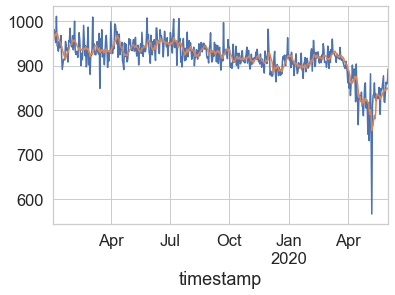

In [677]:
DAILY['avg_flight_dist'].plot(kind='line', x='date', y='avg_flight_dist', alpha=1)
DAILY['avg_flight_dist_7MA'].plot(kind='line', x='date', y='avg_flight_dist_7MA', alpha=1)

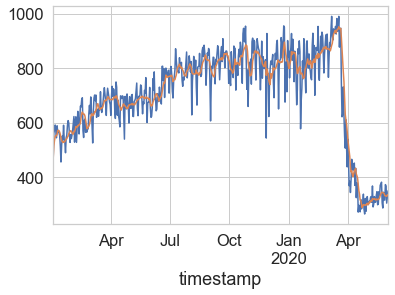

In [678]:
DAILY['daily_departures'].plot(kind='line', x='date', y='daily_departures', alpha=1)
DAILY['daily_departures_7MA'].plot(kind='line', x='date', y='daily_departures_7MA', alpha=1)

## Weekly upsampling

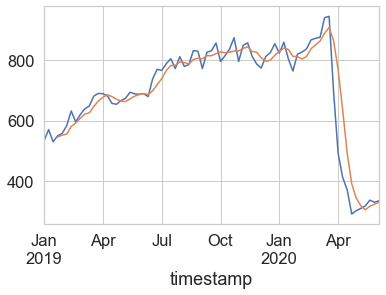

In [679]:
## Weekly upsampling - USIING DAILY df from above
WEEKLY = DAILY.resample('W-Fri', label='right', closed = 'right').mean()
### 4 week moving average
WEEKLY['daily_departures_7MA'] = WEEKLY['daily_departures'].rolling(window=4).mean()
WEEKLY['avg_flight_dist_7MA'] = WEEKLY['avg_flight_dist'].rolling(window=4).mean()
#PLOT
WEEKLY['daily_departures'].plot(kind='line', x='date', y='daily_departures', alpha=1)
WEEKLY['daily_departures_7MA'].plot(kind='line', x='date', y='daily_departures_7MA', alpha=1)
# WEEKLY.tail()

## Monthly upsampling

In [680]:
## Weekly upsampling - USIING DAILY df from above
MONTHLY = DAILY.resample('M', label='right', closed = 'right').mean()

MONTHLY['daily_departures_7MA'] = MONTHLY['daily_departures'].rolling(window=4).mean()
MONTHLY['avg_flight_dist_7MA'] = MONTHLY['avg_flight_dist'].rolling(window=4).mean()
#PLOT

# MONTHLY['daily_departures_7MA'].plot(kind='line', x='date', y='daily_departures_7MA', alpha=1)
### 4 week moving average

In [699]:
MONTHLY['daily_departures'].plot(kind='line', x='date', y='daily_departures', alpha=1)
MONTHLY['daily_departures_7MA'].plot(kind='line', x='date', y='daily_departures_7MA', alpha=1)

In [682]:
# MONTHLY.head()
MONTHLY['miles_per_day'] = MONTHLY['avg_flight_dist']*MONTHLY['daily_departures']
# MONTHLY['miles_per_day']  = MONTHLY['avg_flight_dist']*MONTHLY['daily_departures']
MONTHLY.drop(columns=['daily_departures_7MA','avg_flight_dist_7MA'],inplace=True)


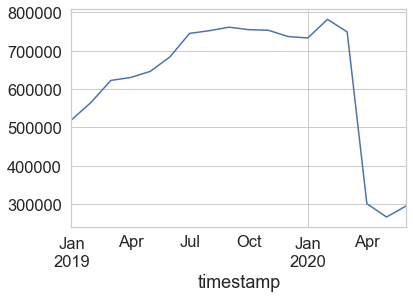

In [683]:
# MONTHLY.head()
MONTHLY['miles_per_day'].plot(kind='line', x='date', y='miles_per_day', alpha=1)
MONTHLY.drop(columns=['avg_flight_dist','daily_departures'],inplace=True)

In [686]:
MONTHLY.head()

,miles_per_day
timestamp,
2019-01-31,519359.360092
2019-02-28,565131.841203
2019-03-31,622225.342427
2019-04-30,629852.666278
2019-05-31,645774.560508


In [687]:
#### dont run again! upu'll roll back date $####
paddname = ('_p'+str(PADD_NUM)) # for headers
date_name = 'date'+paddname # for headers
temp_ind = MONTHLY.index
MONTHLY['date'] = MONTHLY.index.astype('datetime64[ns]')
MONTHLY['date'] = pd.to_datetime(MONTHLY.date) + pd.offsets.MonthBegin(-1) # set to beginign of month
MONTHLY['date'] = MONTHLY['date'].astype('datetime64[ns]')
MONTHLY.set_index(["date"], inplace = True, drop = False)
MONTHLY = MONTHLY.rename_axis("period")
#### changifn headers to padd-5
MONTHLY = MONTHLY.add_suffix(paddname)
MONTHLY.rename(columns={date_name: 'date'}, inplace=True)
MONTHLY.head()
#### dont run again! upu'll roll back date $####

,miles_per_day_p4,date
period,,
2019-01-01,519359.360092,2019-01-01
2019-02-01,565131.841203,2019-02-01
2019-03-01,622225.342427,2019-03-01
2019-04-01,629852.666278,2019-04-01
2019-05-01,645774.560508,2019-05-01


In [688]:
### balances shoud have 
BALANCES = pd.merge(BALANCES,MONTHLY,how = 'left')
BALANCES.set_index(["date"], inplace = True, drop = False)
BALANCES = BALANCES.rename_axis("period")
BALANCES.head(5)

,Days in Month,Year,month,date,PADD 1,PADD 2,PADD 3,PADD 4,PADD 5,Canada,NA_TOTAL,US,miles_per_day_p5,miles_per_day_p1,miles_per_day_p3,miles_per_day_p2,miles_per_day_p4
0,31,2019,1,2019-01-01,580,280,209,57,503,162,"1,792","1,629",4.151259e+06,5.087577e+06,1.646092e+06,1.855805e+06,519359.360092
1,28,2019,2,2019-02-01,576,275,211,56,485,156,"1,760","1,603",4.701964e+06,5.241813e+06,1.611246e+06,2.016050e+06,565131.841203
2,31,2019,3,2019-03-01,694,293,150,57,515,150,"1,860","1,709",5.143258e+06,4.837404e+06,1.633651e+06,2.209877e+06,622225.342427
3,30,2019,4,2019-04-01,615,289,214,61,571,170,"1,921","1,750",5.429963e+06,4.649622e+06,1.645386e+06,2.271145e+06,629852.666278
4,31,2019,5,2019-05-01,647,311,222,57,544,149,"1,931","1,781",5.670406e+06,5.604643e+06,1.785200e+06,2.308170e+06,645774.560508


In [690]:
BALANCES.set_index(["date"], inplace = True, drop = False)
BALANCES = BALANCES.rename_axis("period")

In [707]:
# BALANCES.head(10)

In [703]:
P1_model =  sm.OLS(BALANCES['miles_per_day_p1'],BALANCES['PADD 1'],missing='drop').fit().summary()
P1_model =  sm.OLS(BALANCES['miles_per_day_p2'],BALANCES['PADD 2'],missing='drop').fit().summary()
P1_model =  sm.OLS(BALANCES['miles_per_day_p3'],BALANCES['PADD 3'],missing='drop').fit().summary()
P1_model =  sm.OLS(BALANCES['miles_per_day_p4'],BALANCES['PADD 4'],missing='drop').fit().summary()
P1_model =  sm.OLS(BALANCES['miles_per_day_p5'],BALANCES['PADD 5'],missing='drop').fit().summary()

## pretty good model

In [704]:
P1_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       miles_per_day_p5   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              2391.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):                    9.93e-20
Time:                        04:56:39   Log-Likelihood:                         -258.80
No. Observations:                  18   AIC:                                      519.6
Df Residuals:                      17   BIC:                                      520.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PADD 5      1.018e+04    208.111     48.894      0.000    9736.387    1.06e+04
==============================================================================
Omnibus:                        1.847   Durbin-Watson:                   1.046
Prob(Omnibus):                  0.397   Jarque-Bera (JB):                0.740
Skew:                          -0.483   Prob(JB):                        0.691
Kurtosis:                       3.235   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [706]:
BALANCES.to_csv('monthly_balances.csv')

In [ ]:
IN_PADD_1 = ['ATL','JFK','EWR','CLT','MIA','BOS','FLL','PHL','LGA','BWI','IAD','DCA','TPA','RDU','PIT','BUF']
IN_PADD_2 = ['ORD','MSP','DTW','MDW','BNA','STL','MCI','CLE','IND','CMH','MKE','OMA']
IN_PADD_3 = ['DFW','IAH','DAL','AUS','HOU','SAT','ABQ']
IN_PADD_4 = ['DEN','SLC']
IN_PADD_5 = ['LAX','SFO','SEA','LAS','PHX','SAN','PDX','SJC','OAK','SMF','SNA','BUR','ANC']